# Generate a Detailed Contact Map from Simulation Outputs

Experiment with ways of efficiently generating near-neighbor lists for evaluation of pairwise contact frequencies.

### Import Modules

In [1]:
import os
import sys
import pickle
from pprint import pprint
from typing import Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
path_to_codebase = "../chromo/chromo_two_mark_phase_transition"
sys.path.insert(1, f"{os.getcwd()}/{path_to_codebase}")

In [3]:
import chromo.fields as fd

### Specify Simulations

In [4]:
output_dir = "/scratch/users/jwakim/chromo_two_mark_phase_transition/output"
field_file = "UniformDensityField"
sim_ind = 34
num_equilibrate = 180
polymer_prefix = "Chr"
nbr_cutoff_dist = 10.0
sim_dir = f"{output_dir}/sim_{sim_ind}"
contact_map_path = f"{sim_dir}/detailed_contact_map.csv"
log_contact_map_path = f"{sim_dir}/log_detailed_contact_map.csv"

neighbor_graph_pickle_file = f'{sim_dir}/nbr_graph.pkl'
neighbor_graph_found = os.path.exists(neighbor_graph_pickle_file)
overwrite_neighbor_graph = False
if overwrite_neighbor_graph:
    neighbor_graph_found = False

snapshots = os.listdir(sim_dir)
snapshots = [snap for snap in snapshots if snap.startswith(polymer_prefix) and snap.endswith(".csv")]
snap_inds = [int(snap.split(".")[0].split("-")[-1]) for snap in snapshots]
snapshots = [snap for _, snap in sorted(zip(snap_inds, snapshots))]
snap_inds = np.sort(snap_inds)

### Initialize Voxels

It is too computationally expensive to explicitly calculate pairwise distances between beads. Instead, we need to subset beads to voxels larger than the contact cutoff distance. Then, for all beads within neighboring voxels, we can check pairwise distances and if they fall within the cutoff, we can assign those beads as neighbors.

All beads falling within `nbr_cutoff_dist` of one-another need to be in neighboring voxels. To guarentee this is the case, the voxel width should be at least `nbr_cutoff_dist`.

In [5]:
field_params = pd.read_csv(f"{sim_dir}/{field_file}", header=None, names=["Attribute", "Value"], index_col=0)
x_width = float(field_params.loc["x_width"]["Value"])
y_width = float(field_params.loc["y_width"]["Value"])
z_width = float(field_params.loc["z_width"]["Value"])
nx = int(round(np.floor(x_width / nbr_cutoff_dist)))
ny = int(round(np.floor(y_width / nbr_cutoff_dist)))
nz = int(round(np.floor(z_width / nbr_cutoff_dist)))
n_bins = nx * ny * nz

### Generate Neighbor Graph

This section can take several minutes to compute, especially for a full-chromosome simulation. If you have previously pickled the neighbor graph, you can skip running the code in this section.

In [6]:
if not neighbor_graph_found:
    nbr_bins = fd.get_neighboring_bins(nx, ny, nz)

In [7]:
def get_neighbors(
    r: np.ndarray, num_beads: int, cutoff_dist: float, nbr_bins: Dict[int, List[int]]
) -> Dict[int, List[int]]:
    """Generate graph of neighboring nucleosomes.
    
    Parameters
    ----------
    r : np.ndarray (N, 3) of float
        Cartesian coordinate of each bead in the chromatin fiber;
        rows represent individual beads; columns indicate (x, y, z)
        coordinates
    num_beads : int
        Number of beads representing the chromatin fiber
    cutoff_dist : float
        Cutoff distance between beads below which constitutes a
        near neighbor
    nbr_bins : Dict[int, List[int]]
        Mapping of voxel index to adjacent voxel indices

    Returns
    -------
    Dict[int, List[int]]
        Mapping of each bead index (key) to a list of neighboring
        bead indices (values)
    """
    neighbors = {i: set() for i in range(num_beads)}
    
    beads_in_bins = fd.assign_beads_to_bins(
        np.ascontiguousarray(r), num_beads,
        nx, ny, nz, x_width, y_width, z_width
    )
    
    for bin_1 in beads_in_bins.keys():
        for bin_2 in nbr_bins[bin_1]:
            for bead_1 in beads_in_bins[bin_2]:
                for bead_2 in beads_in_bins[bin_2]:
                    dist = np.linalg.norm(r[bead_1] - r[bead_2])
                    if dist < cutoff_dist:
                        if bead_2 not in neighbors[bead_1]:
                            neighbors[bead_1].add(bead_2)
                        if bead_1 not in neighbors[bead_2]:
                            neighbors[bead_2].add(bead_1)
    return neighbors

In [8]:
if not neighbor_graph_found:
    initialized = False
    neighbor_graphs = {}

    for i, snap in enumerate(snapshots):

        snap_ind = snap_inds[i]

        if snap_ind < num_equilibrate:
            continue

        else:
            print(snap)
            r = pd.read_csv(f"{sim_dir}/{snap}", header=[0, 1], index_col=0).iloc[:, :3].values

            if not initialized:
                num_beads = len(r)
                initialized = True

            neighbors = get_neighbors(r, num_beads, nbr_cutoff_dist, nbr_bins)
            neighbor_graphs[snap] = neighbors

else:
    r_example = pd.read_csv(f"{sim_dir}/{snapshots[0]}", header=[0, 1], index_col=0).iloc[:, :3].values
    num_beads = len(r_example)

### Save the Neighbor Graph

To avoid reproducing the neighbor graph from scratch, we will save the neighbor list to a pickle file. The pickle file can be "de-pickled" in a later Python session to load the neighbor graph.

To save the neighbor graph to a pickle file, run the code block that calls `pickle.dump`. To load the neighbor graph, run the code block that calls `pickle.load`.

In [9]:
if not neighbor_graph_found:
    with open(neighbor_graph_pickle_file, 'wb') as f:
        pickle.dump(neighbor_graphs, f)
else:
    print("Neighbor graph already exists.")

Neighbor graph already exists.


In [10]:
with open(neighbor_graph_pickle_file, 'rb') as f:
    neighbor_graphs = pickle.load(f)

### Analyze Neighbor Graph

Neighboring beads are represented as an unweighted graph using linked lists for each simulation snapshot. Snapshot names are stored as keys in `neighbor_graphs` and linked list graph representations are stored in the values. The graph representation of neighboring beads allows us to efficiently analyze neighbor distributions using the `networkx` module.

In [11]:
## Coming Soon!

### Generate Contact Matrix

We will generate a contact matrix using the neighbor graph. If the chromatin fiber is larger than the dimensions of the contact matrix, we will interpolate bead indices into the contact matrix.

In [12]:
cmap_num_bins = 1000
supports_full_polymer = (cmap_num_bins >= num_beads)
if supports_full_polymer:
    cmap_num_bins = num_beads
    cmap_bin_width = 1
else:
    cmap_bin_width = num_beads / cmap_num_bins

In [13]:
cmap = np.zeros((cmap_num_bins+1, cmap_num_bins+1))

for snap in neighbor_graphs.keys():
    print(f"Snapshot: {snap}")
    graph = neighbor_graphs[snap]
    
    for bead_0 in graph.keys():
        
        # Interpolate bead_1 position in contact map
        if supports_full_polymer:
            x0 = bead_0
            x1 = x0+1
            w_x0 = 1
            w_x1 = 0
        else:
            x0 = int(np.floor(bead_0 / cmap_bin_width))
            x1 = x0 + 1
            w_x0 = 1 - ((bead_0 / cmap_bin_width) - x0)
            w_x1 = 1 - w_x0

        for bead_1 in graph[bead_0]:
            
            # Interpolate bead_2 position in contact map
            if supports_full_polymer:
                y0 = bead_1
                y1 = y0+1
                w_y0 = 1
                w_y1 = 0
            else:
                y0 = int(np.floor(bead_1 / cmap_bin_width))
                y1 = y0+1
                w_y0 = 1 - ((bead_1 / cmap_bin_width) - y0)
                w_y1 = 1 - w_y0
            
            # Bilinear Interpolation Weightings
            w00 = w_x0 * w_y0
            w01 = w_x0 * w_y1
            w10 = w_x1 * w_y0
            w11 = w_x1 * w_y1

            cmap[x0, y0] += w00
            cmap[x0, y1] += w01
            cmap[x1, y0] += w10
            cmap[x1, y1] += w11

# Contacts are double-counted
cmap /= 2

# Average over snapshots
cmap /= len(neighbor_graphs.keys())

Snapshot: Chr_refine-180.csv
Snapshot: Chr_refine-181.csv
Snapshot: Chr_refine-182.csv
Snapshot: Chr_refine-183.csv
Snapshot: Chr_refine-184.csv
Snapshot: Chr_refine-185.csv
Snapshot: Chr_refine-186.csv
Snapshot: Chr_refine-187.csv
Snapshot: Chr_refine-188.csv
Snapshot: Chr_refine-189.csv
Snapshot: Chr_refine-190.csv
Snapshot: Chr_refine-191.csv
Snapshot: Chr_refine-192.csv
Snapshot: Chr_refine-193.csv
Snapshot: Chr_refine-194.csv
Snapshot: Chr_refine-195.csv
Snapshot: Chr_refine-196.csv
Snapshot: Chr_refine-197.csv
Snapshot: Chr_refine-198.csv
Snapshot: Chr_refine-199.csv


In [14]:
np.savetxt(contact_map_path, cmap)

In [15]:
log_cmap = np.log10(cmap+1)

In [16]:
np.savetxt(log_contact_map_path, log_cmap)

### Plot Contact Map

We remove the main diagonal from the plot, since self-contacts are trivial.

In [17]:
log_cmap_plot = log_cmap.copy()
upper_percentile_signals = np.percentile(log_cmap_plot, 99)
max_scale = 5
log_cmap_plot *= max_scale / upper_percentile_signals

# max_scale = np.ceil(np.max(log_cmap_plot))

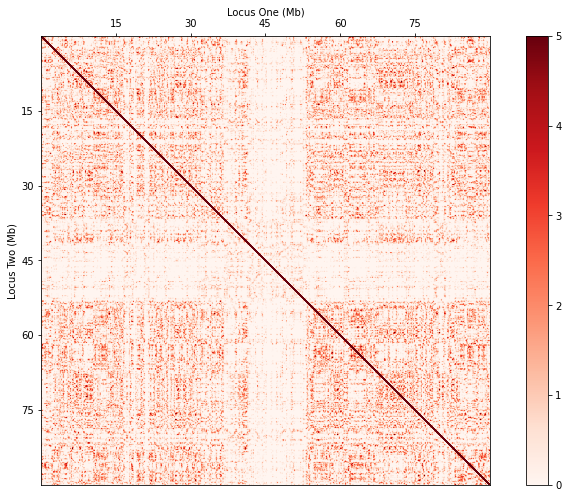

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.5)
extents = [0, 90, 90, 0]
im = ax.imshow(log_cmap_plot, cmap="Reds", extent=extents, vmin=0, vmax=max_scale)
ax.set_xticks([15, 30, 45, 60, 75])
ax.set_yticks([15, 30, 45, 60, 75])
ticks = np.arange(max_scale+1)
boundaries = np.linspace(0, max_scale, 1000)
ax.set_xlabel("Locus One (Mb)")
ax.set_ylabel("Locus Two (Mb)")
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()
fig.colorbar(im, cax=cax, orientation='vertical', ticks=ticks, boundaries=boundaries)
plt.tight_layout()
plt.show()